# Training and Testing
此notebook将引导您完成训练与预测过程，其前身是首次构建模型过程中超参数调优等绝大部分非可视化工作的尝试地方

您需要正确安装以下依赖库：
* pandas
* numpy
* xgboost
* scikit-learn
* imbalanced-learn

如果您有调用神经网络的需求，还需要：
* tensorflow >= 2.0.0

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc

## 特征的变换与增加
受到kaggle上[高分选手经验](https://www.kaggle.com/c/GiveMeSomeCredit/discussion/1166)的启发，添加或修改特征可以提高最终的模型性能。进调试后，因此最终添加至20个特征。

详细的添加思路请参阅项目报告。

In [2]:
def add_features(data):
    # 家属数量
    data['NoDependents'] = data['NumberOfDependents'] == 0
    data['NumberOfDependents'].fillna(0, inplace=True)  #如果是nan，那么NoDependents不会是0

    # 钱取对数，补0，但补出来的0则NoMonthlyIncome不会是1
    data['NoIncome'] = data['MonthlyIncome'] == 0
    data['LogIncome'] = np.log(data['MonthlyIncome'])
    data.loc[~np.isfinite(data['LogIncome']), 'LogIncome'] = 0
    data.loc[pd.isnull(data['LogIncome']), 'LogIncome'] = 0
    
    # 手动分箱&年龄
    data['LowIncome'] = data['MonthlyIncome'] < 180  # 事实证明这个有点重要，由下方calc WOE确定
    data['YoungAge'] = data['age'] < 24
    data['OldAge'] = data['age'] > 65
    
    # 取个对数效果不错
    data['LogAge'] = np.log(data['age'])

    # 月收入对家属数平均
    data['LogIncomePerPerson'] = data['LogIncome'] / data['NumberOfDependents']
    data.loc[~np.isfinite(data['LogIncomePerPerson']), 'LogIncomePerPerson'] = 0  # 暴力处理（反正有标记）
    
    # 负债率乘月收入（本地与kaggle均证明乘取了对数后的月收入效果更好）
    data['NoDebtRatio'] = data['DebtRatio'] == 0
    data['LogDebtRatio'] = np.log(data['DebtRatio'])
    data.loc[~np.isfinite(data['LogDebtRatio']), 'LogDebtRatio'] = 0
    data['LogDebt'] = np.log(data['DebtRatio'] * data['LogIncome'])
    data.loc[~np.isfinite(data['LogDebt']), 'LogDebt'] = 0    # 暴力处理，有标记（但现在没了），非无穷值最低-8.2
    
    data['LogDebtPerPerson'] = data['LogDebt'] / data['NumberOfDependents']
    data.loc[~np.isfinite(data['LogDebtPerPerson']), 'LogDebtPerPerson'] = 0   # 暴力处，非无穷值最低-7.07

    # 对RevolvingUtilizationOfUnsecuredLines取对数
    data['NoRevolvingUtilizationOfUnsecuredLines'] = data['RevolvingUtilizationOfUnsecuredLines']==0 # 无标记，加上后显著提升AUC
    data['LogRevolvingUtilizationOfUnsecuredLines'] = np.log(data['RevolvingUtilizationOfUnsecuredLines'])
    data.loc[~np.isfinite(data['LogRevolvingUtilizationOfUnsecuredLines']), 'LogRevolvingUtilizationOfUnsecuredLines'] = 0

    # 以下列不要了
    data.drop(['MonthlyIncome', 'age', 'RevolvingUtilizationOfUnsecuredLines', 'DebtRatio'], axis=1, inplace=True)

#     print(data.columns)
    return data

## 数据读取
在读取的同时做数据清洗，清洗策略基于可视化过程确定，目前有：
* 删除重复条目
* 删除年龄为0的条目
* 删除30-59天内违约数不小于80的条目

In [3]:
data = pd.read_csv('cs-training.csv', index_col=0)
data.drop_duplicates(inplace=True)
data = data[data['age']!=0]
data = data[data['NumberOfTime30-59DaysPastDueNotWorse']<80]

data.index=range(data.shape[0])

### 尝试lowInome边界
使用WOE作为依据，尝试150附近的数，并结合交叉验证集选定

并非必要执行，只是留档

In [4]:
def calc_WOE_binary(X, y, interval):
    X = X.copy()
    X[np.isnan(X)] = 0
    
    tot1 = np.sum(y == 0)
    tot2 = np.sum(y == 1)
    
    c1 = np.sum((y == 0) & (X < interval))
    c2 = np.sum((y == 1) & (X < interval))
    
    WOE1 = np.log(c1/tot1 / (c2/tot2))
    
    c1 = np.sum((y == 0) & (X >= interval))
    c2 = np.sum((y == 1) & (X >= interval))
    
    WOE2 = np.log(c1/tot1 / (c2/tot2))
    
    return WOE1, WOE2

# 180效果不错，180为低收入分界线
print(calc_WOE_binary(data['MonthlyIncome'].values, data['SeriousDlqin2yrs'].values, 180))

(0.22442932243062408, -0.05316683728078431)


### 为数据集增加特征
调用函数

In [5]:
data = add_features(data)
data.describe()

D:\Anaconda3\envs\tf2\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,SeriousDlqin2yrs,NumberOfTime30-59DaysPastDueNotWorse,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,LogIncome,LogAge,LogIncomePerPerson,LogDebtRatio,LogDebt,LogDebtPerPerson,LogRevolvingUtilizationOfUnsecuredLines
count,149165.000000,149165.000000,149165.000000,149165.000000,149165.000000,149165.000000,149165.000000,149165.000000,149165.000000,149165.000000,149165.000000,149165.000000,149165.000000,149165.000000
mean,0.066188,0.246720,8.493688,0.090725,1.023927,0.065069,0.740911,6.768152,3.915398,2.137131,0.101741,0.463354,0.191670,-1.839850
std,0.248612,0.698935,5.129841,0.486354,1.130350,0.330675,1.108534,3.547192,0.297364,3.242984,3.540340,1.259980,0.599487,1.787633
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.044522,0.000000,-10.557414,-8.200695,-7.069207,-11.690857
25%,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,7.377759,3.713572,0.000000,-1.632189,0.000000,0.000000,-2.991709
50%,0.000000,0.000000,8.000000,0.000000,1.000000,0.000000,0.000000,8.389360,3.951244,0.000000,-0.947048,0.623187,0.000000,-1.466526
75%,0.000000,0.000000,11.000000,0.000000,2.000000,0.000000,1.000000,8.910721,4.143135,4.173321,0.000000,1.273040,0.317553,-0.280433
max,1.000000,13.000000,58.000000,17.000000,54.000000,11.000000,20.000000,14.917035,4.691348,13.885503,12.705829,6.928889,6.619291,10.833839


## 神经网络训练
仅是函数定义，实际运行需要：
* tensorflow >= 2.0.0

In [6]:
def train_nn(X, y, X_test):
    from tensorflow import keras
    from tensorflow.keras import models, regularizers
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import SGD
    from tensorflow.keras.callbacks import LearningRateScheduler
        
    # 标准化
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    X_test = scaler.transform(X_test)
    
    _wd, batch_size, epochs = 1e-4, 512, 10
    
    model = models.Sequential([
        Dense(25, activation='sigmoid', kernel_regularizer=regularizers.l2(_wd)),
        Dropout(0.1),
        Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(_wd))
    ])
    model.compile(optimizer=SGD(lr=0.05, momentum=0.99), loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(X, y, epochs = epochs, batch_size=batch_size, callbacks=[LearningRateScheduler(lambda e: 0.05 if e <= 5 else 0.01)])
    
    y_prob = model.predict(X)
    y_test = model.predict(X_test)
    
    return y_prob[:,0], y_test[:,0], model

## 训练函数
多模型独立训练，后接线性分类器。

除神经网络外的所有分类器均在此设置超参数。

In [7]:
def fit_classifiers(train, test, apply_nn=False):
    # 大体框架来源于github，加了些东西
    cols = [c for c in train.columns if c not in ['SeriousDlqin2yrs']]

    classifiers = dict()
#     classifiers['rf'] = RandomForestClassifier(n_estimators=300, learning_rate=0.1)
#     classifiers['gbm'] = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05)
    classifiers['xgb1'] = xgb.XGBClassifier(max_depth=3, n_estimators=320, learning_rate=0.05)
    classifiers['xgb2'] = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
#     classifiers['xgb3'] = xgb.XGBClassifier(max_depth=3, n_estimators=340, learning_rate=0.05)

    # make np arrays from pandas dataframe
    X, y = train[cols].values, train['SeriousDlqin2yrs'].values
    X_test = test[cols].values
    
    # 过采样后，kaggle评分极轻微下降，但测试结果的0-1分布更平滑
    from imblearn.over_sampling import RandomOverSampler, SMOTE
    resampler = RandomOverSampler()
#     resampler = SMOTE() # 此处可加参数kind='borderline1','borderline2','svm'
    
    print(X.shape)
    X, y = resampler.fit_sample(X, y)
    print(X.shape)
    
    model_num = len(classifiers)
    if apply_nn:
        model_num += 1
    train_probs = np.zeros((X.shape[0], model_num))
    test_probs = np.zeros((X_test.shape[0], model_num))
    
    # 5-flod交叉验证
    N_folds = 5
    folds = StratifiedKFold(n_splits=N_folds)
    
    for clf_idx, clf in enumerate(classifiers.values()):
        current_test = np.zeros((test.shape[0], N_folds))
        print("clf_idx = ", clf_idx)
        for fold_idx, (fold_train, fold_test) in enumerate(folds.split(X, y)):
            print("fold_idx = ", fold_idx)
            clf.fit(X[fold_train], y[fold_train])
            train_probs[fold_test, clf_idx] = clf.predict_proba(X[fold_test])[:,1]  # 只用预测值更新本次作为交叉验证的那些
            current_test[:, fold_idx] = clf.predict_proba(X_test)[:,1]
        test_probs[:, clf_idx] = current_test.mean(axis=1)

    if apply_nn:
        train_probs[:, -1], test_probs[:, -1], classifiers['nn'] = train_nn(X, y, X_test)
    
    # solver仅支持以下几个参数'liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'
    print('Training linear')
    logistic = LogisticRegression(solver='liblinear').fit(train_probs, y)
    
    probs_t = logistic.predict_proba(train_probs)[:,1]
    fpr, tpr, _ = roc_curve(y, probs_t)
    print('AUC of train', auc(fpr, tpr))
    
    probs = logistic.predict_proba(test_probs)[:,1]
    
    classifiers['final-linear'] = logistic

    return probs, classifiers

## 本地训练(调参用)
首先分出30%作为验证集，不参与训练。

注：默认开启使用神经网络，关闭请将```apply_nn```设置为```False```

输出训练集与测试集的AUC（非必须执行）

In [8]:
train, validate = train_test_split(data, test_size=0.3)

result, model = fit_classifiers(train, validate, apply_nn=True) # 不使用神经网络请将apply_nn设为False
fpr, tpr, _ = roc_curve(validate['SeriousDlqin2yrs'], result)
print('AUC of test', auc(fpr, tpr))

(104415, 20)
(194990, 20)
clf_idx =  0
fold_idx =  0
fold_idx =  1
fold_idx =  2
fold_idx =  3
fold_idx =  4
clf_idx =  1
fold_idx =  0
fold_idx =  1
fold_idx =  2
fold_idx =  3
fold_idx =  4
Train on 194990 samples
Epoch 1/10
194990/194990 [==============================] - 6s 29us/sample - loss: 0.5425 - accuracy: 0.7372
Epoch 2/10
194990/194990 [==============================] - 1s 5us/sample - loss: 0.4912 - accuracy: 0.7728
Epoch 3/10
194990/194990 [==============================] - 1s 5us/sample - loss: 0.4866 - accuracy: 0.7742
Epoch 4/10
194990/194990 [==============================] - 1s 5us/sample - loss: 0.4850 - accuracy: 0.7737
Epoch 5/10
194990/194990 [==============================] - 1s 5us/sample - loss: 0.4839 - accuracy: 0.7742
Epoch 6/10
194990/194990 [==============================] - 1s 5us/sample - loss: 0.4829 - accuracy: 0.7742
Epoch 7/10
194990/194990 [==============================] - 1s 5us/sample - loss: 0.4863 - accuracy: 0.7727
Epoch 8/10
194990/194990 [=

## 真正训练（预测用）
不分验证集，全部作为训练集训练，同时预测测试集，适用于超参数调整好后重新训练。

默认不使用神经网络。

将重新从文件读取数据。

最终结果与随机种子有关，最高达到0.86780，平均0.86772.

In [9]:
data  = pd.read_csv('cs-training.csv',index_col=0)
test  = pd.read_csv('cs-test.csv', index_col=0)

data.drop_duplicates(inplace=True)
data = data[data['age']!=0]
data = data[data['NumberOfTime30-59DaysPastDueNotWorse']<80]
data.index=range(data.shape[0])

# np.random.seed(0)

test.drop('SeriousDlqin2yrs', axis=1, inplace=True)
# 增加特征
data = add_features(data)
test = add_features(test)

probs, models = fit_classifiers(data, test, apply_nn=False) # 使用神经网络请将apply_nn设为True

print("Done!")

D:\Anaconda3\envs\tf2\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(149165, 20)
(278584, 20)
clf_idx =  0
fold_idx =  0
fold_idx =  1
fold_idx =  2
fold_idx =  3
fold_idx =  4
clf_idx =  1
fold_idx =  0
fold_idx =  1
fold_idx =  2
fold_idx =  3
fold_idx =  4
Training linear
AUC of train 0.8720449603672547
Done!


## 评分函数定义
评分函数：

$$score = 600-81.8\ln\frac{p}{1-p}$$

其中，81.8的确定经统计学方法分析与计算得到，详见项目报告。

In [10]:
def get_score(p):
    score = 600 - 81.8 * np.log(p/(1-p))
    if score < 300:
        score = 300
    elif score > 900:
        score = 900
    return score

In [11]:
# 同时输出分数
with open("predict_score.csv", 'w') as f:
    f.write('Id,Probability,Score\n')
    for idx, pr in zip(range(1, len(probs)+1), probs):
        f.write('{},{:.9f}, {:.9f}\n'.format(idx, pr, get_score(pr)))

In [12]:
# 不输出分数，仅用于提交
with open("submit.csv", 'w') as f:
    f.write('Id,Probability\n')
    for idx, pr in zip(range(1, len(probs)+1), probs):
        f.write('{},{:.9f}\n'.format(idx, pr))

## 特征重要性
特征f0至f19依次对应columns下标

更直观的可视化请参阅项目报告或Visualization.ipynb

Index(['NumberOfTime30-59DaysPastDueNotWorse',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'NoDependents', 'NoIncome', 'LogIncome',
       'LowIncome', 'YoungAge', 'OldAge', 'LogAge', 'LogIncomePerPerson',
       'NoDebtRatio', 'LogDebtRatio', 'LogDebt', 'LogDebtPerPerson',
       'NoRevolvingUtilizationOfUnsecuredLines',
       'LogRevolvingUtilizationOfUnsecuredLines'],
      dtype='object')


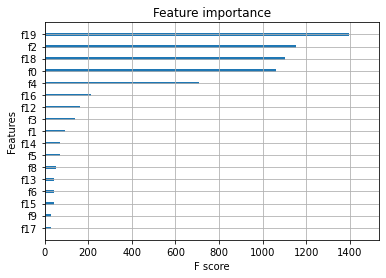

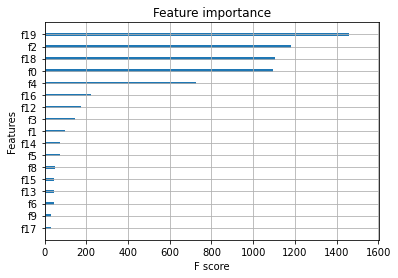

In [13]:
print(test.columns)
xgb.plot_importance(models['xgb1'],importance_type='gain', show_values=False)
xgb.plot_importance(models['xgb2'],importance_type='gain', show_values=False)

In [170]:
# 保存模型
from sklearn.externals import joblib
joblib.dump(models['final-linear'], 'final_linear.model')

for model_name in models:
    if 'xgb' in model_name:
        models[model_name].get_booster().save_model('{}.model'.format(model_name))

# 读取的写法
# lr = joblib.load('final_linear.model')

# tar = xgb.Booster(model_file='xgb.model')
# x_test = xgb.DMatrix(x_test)
# pre=tar.predict(x_test)

## 预测
需要刚刚训练过才可调用，或可以修改从文件读取的代码

输入：一个pd.DataFrame，要求特征没有SeriousDlqin2yrs，其余特征顺序与cs-trainning.csv或cs-test.csv**完全一致**

输出：m维向量p，m为所输入DataFrame的条目数

In [14]:
def predict_probs(df):
    df = add_features(df)
    X = df.values
    
    probs = np.zeros((X.shape[0], 2))
    
    probs[:, 0] = models['xgb1'].predict_proba(X)[:,1]
    probs[:, 1] = models['xgb2'].predict_proba(X)[:,1]
    
    p = models['final-linear'].predict_proba(probs)[:,1]
    return p

In [18]:
# 预测代码
d ={'RevolvingUtilizationOfUnsecuredLines':[0],'age':[0],'NumberOfTime30-59DaysPastDueNotWorse':[0],'DebtRatio':[0],'MonthlyIncome':[0],'NumberOfOpenCreditLinesAndLoans':[0],'NumberOfTimes90DaysLate':[0],'NumberRealEstateLoansOrLines':[0],'NumberOfTime60-89DaysPastDueNotWorse':[0],'NumberOfDependents':[0]}

print("欢迎使用信用卡评分系统,请先输入验证码：2F5X")
s = str(input("验证码"))
if s == "2F5X" :
    print("验证成功\n（除特殊注明外，以下内容请均填入整数阿拉伯数字）")

    print("\n首先输入一些基本情况")
    d['age'][0] = int(input("您的年龄："))
    d['NumberOfDependents'][0] = int(input("您有多少亲属："))
    
    print("\n接下来输入您的财务信息")
    d['MonthlyIncome'][0] = int(input("您的月收入："))
    d['DebtRatio'][0] = float(input("目前的负债比率大概是多少：(0-1间的小数)"))
    d['NumberOfOpenCreditLinesAndLoans'][0] = int(input("您有多少开放式信贷或贷款："))
    d['NumberRealEstateLoansOrLines'][0] = int(input("您有多少不动产信贷或贷款："))
    d['RevolvingUtilizationOfUnsecuredLines'][0] = float(input("最后，您的可用额度比值是多少：(0-1间的小数)"))
        
    print("\n最后是信用记录")
    d['NumberOfTime30-59DaysPastDueNotWorse'][0] = int(input("一个月延期次数："))
    d['NumberOfTime60-89DaysPastDueNotWorse'][0] = int(input("两个月延期次数："))
    d['NumberOfTimes90DaysLate'][0] = int(input("三个月延期次数："))
    
    df = pd.DataFrame(data = d)
    print("您的信用评分是", get_score(predict_probs(df)[0]))

欢迎使用信用卡评分系统,请先输入验证码：2F5X
验证码2F5X
验证成功
（除特殊注明外，以下内容请均填入整数阿拉伯数字）

首先输入一些基本情况
您的年龄：65
您有多少亲属：4

接下来输入您的财务信息
您的月收入：5000
目前的负债比率大概是多少：(0-1间的小数)0.01
您有多少开放式信贷或贷款：0
您有多少不动产信贷或贷款：0
最后，您的可用额度比值是多少：(0-1间的小数)0.05

最后是信用记录
一个月延期次数：0
两个月延期次数：0
三个月延期次数：0
您的信用评分是 756.3757974125027


使用 CC BY-SA 3.0 协议.